## Fitting drug response curves with sigmoid function

1. Test different fitting function:
2. visualise fitting and analyse errors
3. Check for which drug profiles for which some function are fitting with R2>0.9, and others with R2<0.9

In [137]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"

In [138]:
def sigmoid_Wang(x, p, s):
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4
    s - shape parameter, default=-1
    = sigmoid_2_param
    """
    return ( 1.0 / (1.0 + np.exp((x-p)/s)) )


def fsigmoid(x, p, k):
    """ Comparing with Dennis Wang's sigmoid:
    x = x  - dosage [0, 1]
    p - position [0,1],           default=0.4
    k = -1/s (s -shape parameter) default=0.4
    """
    return ( 1.0 / (1.0 + np.exp(-k*(x-p))) )


def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)


def sigmoid_3_param(x, x0, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
        """
    return ( 1/ (1 + np.exp(-k*(x-x0))) + d )


def ll4(x, e, c, b, d):
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     - b: hill slope
     - d: min response - determines the vertical position of the graph
     - c: max response
     - e: EC50
     c-d - difference between max and min responses
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in Dennis Wang's sigmoid
     b- hill slope = 1/s - shape parameter
     np.log(x)-np.log(e) == x-p in Dennis Wang's sigmoid
     """
    return ( (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d)


def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    ll4_R = ll4_R_4_param
    
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


def logistic4(x, A, B, C, d):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    logistic4 = logistic_4_param
    
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in Dennis Wang's sigmoid:
    (x/C)**B  - corresponds to np.exp((x-p)/s
    d - determines the vertical position of the graph
    """
    return ( (A-d)/(1.0+((x/C)**B)) + d )


def logLogistR(x, EC50, HS, E_inf):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    
    logLogistR   = logLogist_3_param
    
    (A - d) = 1 in Dennis Wang's sigmoid:
    (np.log10(x)/EC50)**HS  - (in logistic4 (x/C)**B) corresponds to np.exp((x-p)/s 
    
    E_inf - determines the vertical position of the graph /coefficient d, min response in other functions
    """
    return ((1-E_inf)/(1+(np.log10(x)/EC50)**HS) + E_inf)

def linear(x, a, b):
    """y= ax+b"""
    return a*x +b



def FitCurve(fitting_function, x, y, parameters_guess=None, to_plot = False):
#     from scipy.optimize import curve_fit

    if parameters_guess:
        parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    else: 
        parameters, p_covariance = curve_fit(fitting_function, x, y)
    x2 = np.linspace(0, 1, 10)
    y_fit = fitting_function(x, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters


def FittingColumn(df, indexes, x_columns, y_columns, fitting_function, parameters_guess=None, default_param = False):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    
    # parameters_guess= [np.median(x), 1, max(y), min(y)]
    default_param_model = {"sigmoid_Wang": [0.4, 0.1],
                       "fsigmoid" : [0.4, -10],
                       "sigmoid_4_param": [0.4, 1.0, 1.0, .0],
                       "sigmoid_3_param": [0.4, 1.0, .0],
                       "logistic4": [1.0, 1.0, 1.0, 0.0],
                       "ll4": [0.4, 1.0, 1.0, 0.0],
                       "ll4_R": [0.4, 1.0, 1.0, 0.0],
                       "logLogistR": [-1, -0.1, 0.1]}
    
    if default_param:
        parameters_guess = default_param_model[fitting_function]
       
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        try:
            r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            
        except:
            try:
                functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_Wang": sigmoid_Wang, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic4": logistic4,  
                 "ll4": ll4, 
                 "ll4_R":ll4_R,
                 "logLogistR":logLogistR}
                fitting_function_object = functions[fitting_function]
#                 from fitting_curves.py import fitting_function_object
                r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            except:
                r2_scores[i] = 0
    return r2_scores, fitting_parameters


def ShowResponseCurvesWithFitting(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None, pred_fitting_param = None):
    
    print("Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)")
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) == 0:
        indexes = df.index[start_index : start_index+n_plots]
        
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
        
    try:
        for i in range(len(indexes)):
            x = X[i, :]
            y = Y[i, :]
            ind = indexes[i]

                
            ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")

            if fitting_function:
                functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R": ll4_R, "logLogistR": logLogistR}
                fitting_function_object = functions[fitting_function]
                
#                 from fitting_curves.py import fitting_function_object

                x2 = np.linspace(0, 1, 10)

                if type(fitting_parameters) == str:
                    fit_param = df.loc[ind, fitting_parameters]
                else:

                    fit_param = df.loc[ind, fitting_parameters].values

                y_fit = fitting_function_object(x, *fit_param)
                y2 = fitting_function_object(x2, *fit_param)
                r2 = r2_score(y, y_fit)
                ax.plot(x2, y2, label= "R^2 fit = %0.4f"% r2)
                ax.legend()
            if pred_fitting_param:

                x3 = np.linspace(0, 1, 10) 
                fit_param = df.loc[ind, pred_fitting_param]    
                y_fit3 = fitting_function_object(x, *fit_param)
                y3 = fitting_function_object(x3, *fit_param)
                r2_pred = r2_score(y, y_fit3)
                ax.plot(x3, y3, color="red", label= "R^2 pred = %0.4f"% r2_pred)
                ax.legend()

                
    except:
        print("ERROR: Number of indexes does not correspond to number of graphs to plot")


def compute_r2_score(df, x_columns, y_columns, fitting_parameters, fitting_function="sigmoid_4_param"):
    functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R":ll4_R, "logLogistR": logLogistR}
    fitting_function_object = functions[fitting_function]
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns]
        y = df.loc[df.index[i], y_columns]
        if type(fitting_parameters) == str:
            fit_param = df.loc[df.index[i], fitting_parameters]
        else:
            fit_param = df.loc[df.index[i], fitting_parameters].values
        y_fit = fitting_function_object(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

## Fitting data

In [141]:
df = pd.read_csv("results/filtered_drug_profiles_123.csv")
df1 = pd.read_csv("results/sigmoid_01.csv")
df2 = pd.read_csv("results/sigmoid_02.csv")
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

## Comparison of fitting models

In [142]:
functions = ["sigmoid_Wang", "fsigmoid", 
             "sigmoid_4_param", "sigmoid_3_param",
             "logistic4", "ll4", "ll4_R",
             "logLogistR"]

### Which function gives the best fitting for filtered_123

In [144]:
for fitting_function in functions:
    r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
    df[fitting_function+"_r2"] = r2
    df[fitting_function] = fit_param

functions_dict= dict(list(enumerate(functions)))
r2_columns = [fitting_function+"_r2" for fitting_function in functions]

df["better_fitting"] = np.argmax(df[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df["better_fitting"] = df["better_fitting"].map(functions_dict)
# df[r2_col_res].head()

df["better_fitting"].value_counts()

100%|██████████| 2776/2776 [00:04<00:00, 565.91it/s]


sigmoid_4_param    1122
logLogistR          806
logistic4           321
ll4_R               263
ll4                 262
sigmoid_3_param       2
Name: better_fitting, dtype: int64

### Which function gives the best fitting for sigmoid_01

In [146]:
for fitting_function in functions:
    r2, fit_param = FittingColumn(df1, df1.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
    df1[fitting_function+"_r2"] = r2
    df1[fitting_function] = fit_param

functions_dict= dict(list(enumerate(functions)))
r2_columns = [fitting_function+"_r2" for fitting_function in functions]

df1["better_fitting"] = np.argmax(df1[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df1["better_fitting"] = df1["better_fitting"].map(functions_dict)
# df1[r2_col_res].head()

df1["better_fitting"].value_counts()

100%|██████████| 2600/2600 [00:04<00:00, 566.36it/s]


sigmoid_4_param    1077
logLogistR          761
logistic4           296
ll4                 237
ll4_R               228
sigmoid_3_param       1
Name: better_fitting, dtype: int64

### Which function gives the best fitting for sigmoid_02

In [147]:
for fitting_function in functions:
    r2, fit_param = FittingColumn(df2, df2.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
    df2[fitting_function+"_r2"] = r2
    df2[fitting_function] = fit_param

functions_dict= dict(list(enumerate(functions)))
r2_columns = [fitting_function+"_r2" for fitting_function in functions]

df2["better_fitting"] = np.argmax(df2[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df2["better_fitting"] = df2["better_fitting"].map(functions_dict)
# df2[r2_col_res].head()

df2["better_fitting"].value_counts()

100%|██████████| 2719/2719 [00:04<00:00, 574.70it/s]


sigmoid_4_param    1108
logLogistR          790
logistic4           315
ll4_R               253
ll4                 252
sigmoid_3_param       1
Name: better_fitting, dtype: int64

In [150]:
print("Dataset: filtered_123")
print(df["better_fitting"].value_counts())
print("\nDataset: sigmoid_01")
print(df1["better_fitting"].value_counts())
print("\nDataset: sigmoid_02")
print(df2["better_fitting"].value_counts())

Dataset: filtered_123
sigmoid_4_param    1122
logLogistR          806
logistic4           321
ll4_R               263
ll4                 262
sigmoid_3_param       2
Name: better_fitting, dtype: int64

Dataset: sigmoid_01
sigmoid_4_param    1077
logLogistR          761
logistic4           296
ll4                 237
ll4_R               228
sigmoid_3_param       1
Name: better_fitting, dtype: int64

Dataset: sigmoid_02
sigmoid_4_param    1108
logLogistR          790
logistic4           315
ll4_R               253
ll4                 252
sigmoid_3_param       1
Name: better_fitting, dtype: int64


### What are the values of best fitting?

In [161]:
best_functions = df["better_fitting"].unique()

df_best = pd.DataFrame(index= best_functions, columns = ["count", "min", "max"])
for fitting_function in best_functions:
    r2_fit = df[df["better_fitting"]==fitting_function][fitting_function+"_r2"].values 
#     print(fitting_function, len(r2_fit))
    df_best.loc[fitting_function, "count"] = len(r2_fit)
    df_best.loc[fitting_function, "min"] = min(r2_fit)
    df_best.loc[fitting_function, "max"] = max(r2_fit)

In [157]:
df_best_1 = pd.DataFrame(index= best_functions, columns = ["count", "min", "max"])
for fitting_function in best_functions:
    r2_fit = df1[df1["better_fitting"]==fitting_function][fitting_function+"_r2"].values 
#     print(fitting_function, len(r2_fit))
    df_best_1.loc[fitting_function, "count"] = len(r2_fit)
    df_best_1.loc[fitting_function, "min"] = min(r2_fit)
    df_best_1.loc[fitting_function, "max"] = max(r2_fit)

In [158]:
df_best_2 = pd.DataFrame(index= best_functions, columns = ["count", "min", "max"])
for fitting_function in best_functions:
    r2_fit = df2[df2["better_fitting"]==fitting_function][fitting_function+"_r2"].values 
#     print(fitting_function, len(r2_fit))
    df_best_2.loc[fitting_function, "count"] = len(r2_fit)
    df_best_2.loc[fitting_function, "min"] = min(r2_fit)
    df_best_2.loc[fitting_function, "max"] = max(r2_fit)

In [162]:
print("Dataset: filtered_123")
display(df_best)

print("\nDataset: sigmoid_01")
display(df_best_1)

print("\nDataset: sigmoid_02")
display(df_best_2)

Dataset: filtered_123


,count,min,max
sigmoid_4_param,1122,0.60372,0.999981
ll4_R,263,0.601647,0.999955
logLogistR,806,0.468332,0.999978
logistic4,321,0.625308,0.999861
ll4,262,0.552771,0.999917
sigmoid_3_param,2,0.738437,0.999866



Dataset: sigmoid_01


,count,min,max
sigmoid_4_param,1077,0.918977,0.999981
ll4_R,228,0.924212,0.999955
logLogistR,761,0.87565,0.999978
logistic4,296,0.910614,0.999861
ll4,237,0.929917,0.999917
sigmoid_3_param,1,0.999866,0.999866



Dataset: sigmoid_02


,count,min,max
sigmoid_4_param,1108,0.914612,0.999981
ll4_R,253,0.908181,0.999955
logLogistR,790,0.87565,0.999978
logistic4,315,0.910614,0.999861
ll4,252,0.846249,0.999917
sigmoid_3_param,1,0.999866,0.999866


## Examples of bad fitting

In [163]:
df[df["sigmoid_4_param_r2"]<0.61][["COSMIC_ID", "DRUG_ID"]+r2_col_res].shape

(47, 11)

In [167]:
df2[df2["sigmoid_4_param_r2"]<0.61][["COSMIC_ID", "DRUG_ID"]+r2_col_res].shape

(40, 11)

In [164]:
df1[df1["sigmoid_4_param_r2"]<0.61][["COSMIC_ID", "DRUG_ID"]+r2_col_res].shape

(37, 11)

### Visualise fitting of the same drug profile where it is R2=0.60372 for sigmoid_4_param

In [168]:
df1[df1["sigmoid_4_param_r2"]<0.61][["COSMIC_ID", "DRUG_ID"]+r2_col_res].head()

,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
19,910851,170,0.991346,0.991346,0.000000e+00,0.995994,0.998188,0.998188,0.998188,0.997637,ll4_R
67,1290724,268,0.948049,0.948049,4.978983e-10,0.985379,0.992273,0.992273,0.992273,0.989404,ll4
103,907064,180,0.988098,0.988098,3.819370e-08,0.996652,0.997866,0.997866,0.997866,0.997858,ll4_R
203,1240150,180,0.781777,0.781777,-2.593563e-08,0.957028,0.981340,0.981340,0.981340,0.981363,logLogistR
310,905983,274,0.951995,0.951995,1.573861e-08,0.957321,0.975788,0.975788,0.975788,0.963631,ll4


In [173]:
df1[df1["better_fitting"]== "sigmoid_4_param"][["COSMIC_ID", "DRUG_ID"]+r2_col_res].head()

,COSMIC_ID,DRUG_ID,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
0,909704,308,0.995452,0.995452,0.996467,0.996302,0.993608,0.993608,0.993608,0.996330,sigmoid_4_param
1,908449,157,0.899079,0.899079,0.978440,0.942793,0.978230,0.978230,0.978230,0.977584,sigmoid_4_param
5,1240157,219,0.789260,0.789260,0.998772,0.849201,0.998767,0.998767,0.998767,0.998607,sigmoid_4_param
6,1330933,32,0.881946,0.881946,0.997430,0.953390,0.997363,0.997363,0.997363,0.996971,sigmoid_4_param
7,1330933,60,0.994031,0.994031,0.998849,0.994230,0.998788,0.998788,0.998788,0.997102,sigmoid_4_param


In [178]:
print("Dataset: filtered_123")
print("Number of bad fit with sigmoid_4_param:", df[df["sigmoid_4_param_r2"]<0.61].shape[0])
print("Number of bad fit with logistic4:", df[df["logistic4_r2"]<0.61].shape[0])

print("\nDataset: sigmoid_01")
print("Number of bad fit with sigmoid_4_param:", df1[df1["sigmoid_4_param_r2"]<0.61].shape[0])
print("Number of bad fit with logistic4:", df1[df1["logistic4_r2"]<0.61].shape[0])

print("\nDataset: sigmoid_02")
print("Number of bad fit with sigmoid_4_param:", df2[df2["sigmoid_4_param_r2"]<0.61].shape[0])
print("Number of bad fit with logistic4:", df2[df2["logistic4_r2"]<0.61].shape[0])

Dataset: filtered_123
Number of bad fit with sigmoid_4_param: 47
Number of bad fit with logistic4: 4

Dataset: sigmoid_01
Number of bad fit with sigmoid_4_param: 37
Number of bad fit with logistic4: 0

Dataset: sigmoid_02
Number of bad fit with sigmoid_4_param: 40
Number of bad fit with logistic4: 0


### Hypothesis: sigmoid_4_param is not very robust method?

In [169]:
def show_all_functions_on_one(drug_id, cosmic_id):
    ind =int(df[(df["DRUG_ID"]==drug_id) & (df["COSMIC_ID"]==cosmic_id)].index[0])
    x = df.loc[ind, conc_columns].astype("float32")
    y = df.loc[ind, response_norm].astype("float32")
    plt.scatter(x, y, label ="original", color = 'black')
    plt.tick_params(labelsize=14)
    plt.xlabel("Scaled dosage", fontsize=14)
    plt.ylabel("Normalised Response", fontsize=14)
    markers = [None, ".", "o", "v", "<", ">", "+"]
    plt.title("DRUG_ID: %s, COSMIC_ID: %s" % (drug_id, cosmic_id))
    for i, fitting_function in enumerate(functions):
        fit_param = df.loc[ind, fitting_function]
        y_fit = functions_dict[fitting_function](x, *fit_param)
        r2 = r2_score(y, y_fit)
        plt.plot(x, y_fit, marker = markers[i], label= fitting_function+": %0.4f"% r2)

    # Put a legend below current axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.7, -0.2),
          fancybox=True, shadow=True, ncol=6);

In [170]:
def show_one(drug_id, cosmic_id, fitting_function=None):
    ind =int(df[(df["DRUG_ID"]==drug_id) & (df["COSMIC_ID"]==cosmic_id)].index[0])
    x = df.loc[ind, conc_columns].astype("float32")
    y = df.loc[ind, response_norm].astype("float32")
    plt.scatter(x, y, label ="original", color = 'black')
    plt.tick_params(labelsize=14)
    plt.xlabel("Scaled dosage", fontsize=14)
    plt.ylabel("Normalised Response", fontsize=14)
    plt.title("%s, DRUG_ID: %s, COSMIC_ID: %s" % (fitting_function,drug_id, cosmic_id))
    if fitting_function:
        fit_param = df.loc[ind, fitting_function]
        y_fit = functions_dict[fitting_function](x, *fit_param)
        r2 = r2_score(y, y_fit)
        plt.plot(x, y_fit, marker = markers[i], label= fitting_function+": %0.4f"% r2)
        plt.legend();

In [171]:
functions_dict = {"fsigmoid": fsigmoid, 
                 "sigmoid_Wang": sigmoid_Wang, 
                "sigmoid_4_param": sigmoid_4_param,
                 "logistic4": logistic4,  
                 "ll4": ll4, 
                 "ll4_R":ll4_R,
                 "logLogistR":logLogistR}

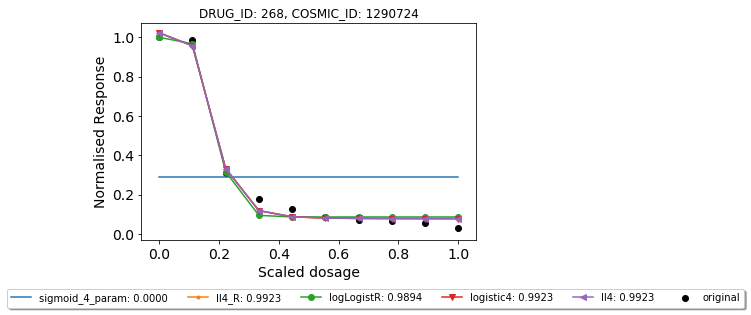

In [115]:
show_all_functions_on_one(drug_id =268, cosmic_id= 1290724)


In [122]:
for fitting_function in functions:
    print(fitting_function, "   Number of samples with R2<0.61:", 
          df[df[fitting_function+"_r2"]<0.61].shape[0])

sigmoid_4_param    Number of samples with R2<0.61: 26
ll4_R    Number of samples with R2<0.61: 6
logLogistR    Number of samples with R2<0.61: 5
logistic4    Number of samples with R2<0.61: 4
ll4    Number of samples with R2<0.61: 4


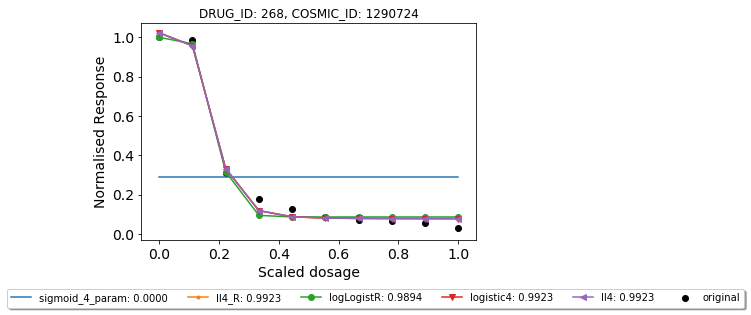

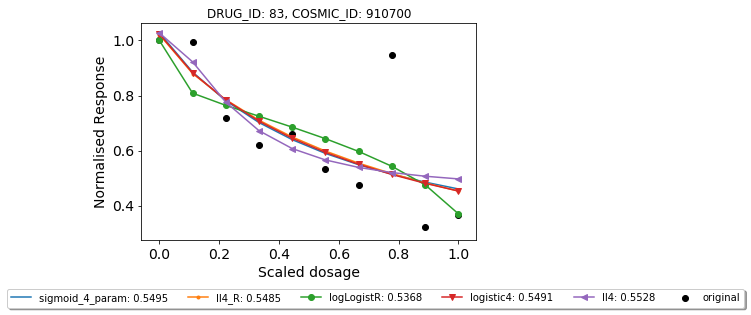

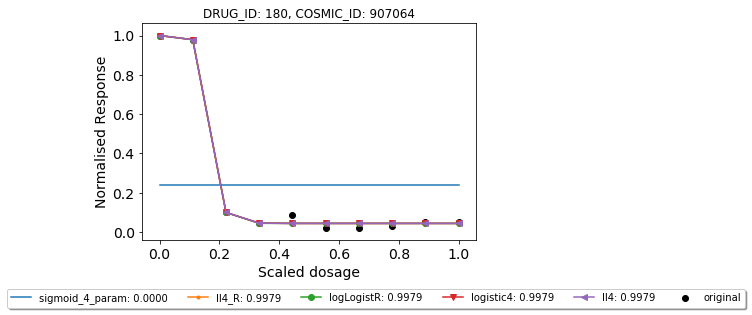

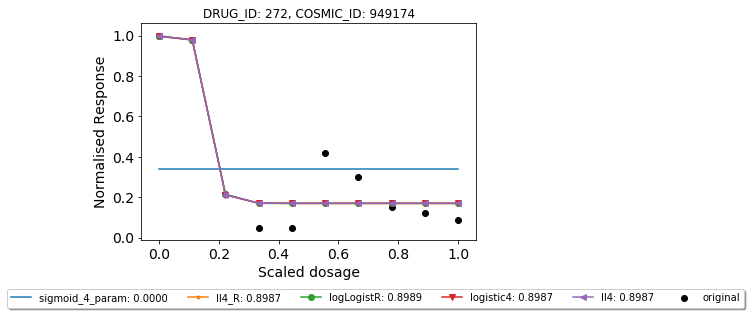

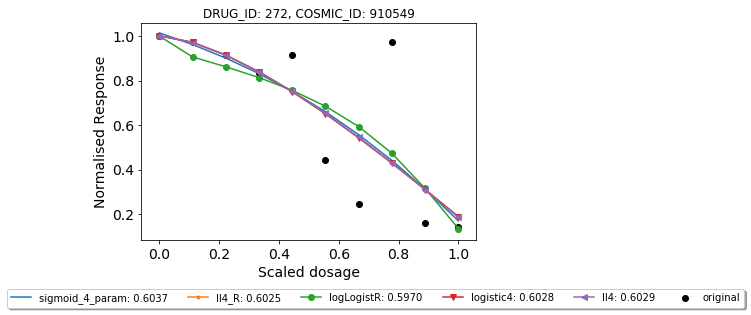

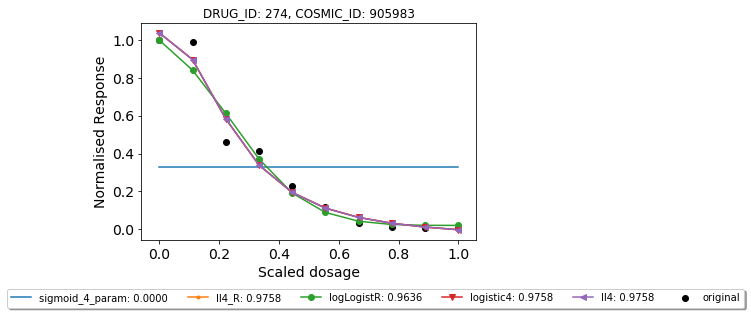

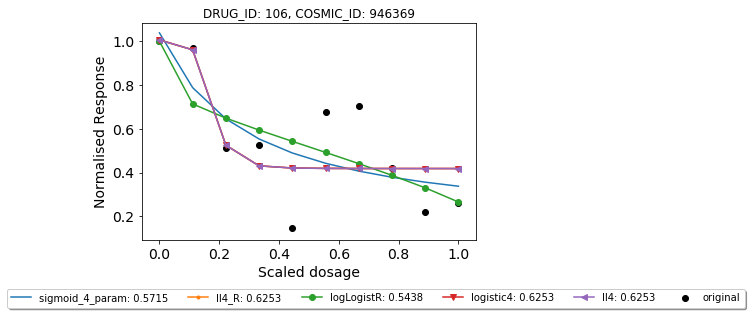

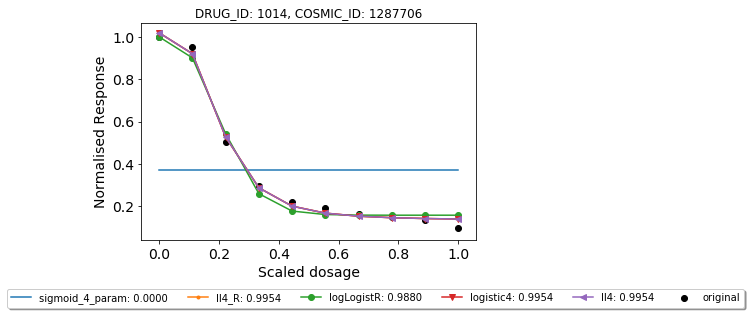

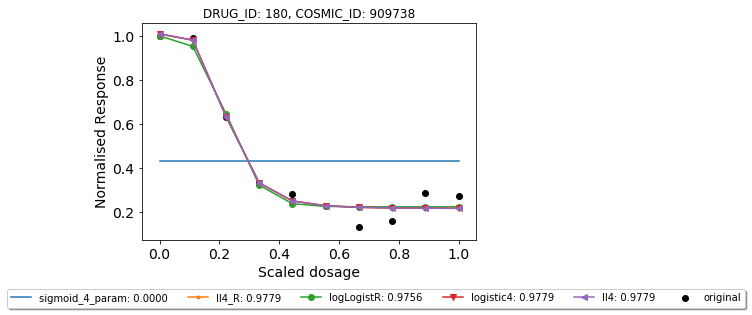

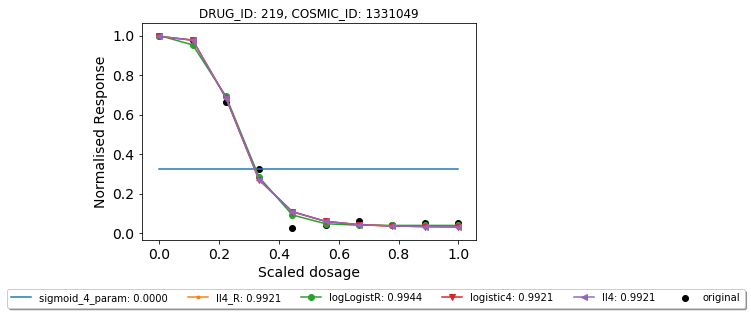

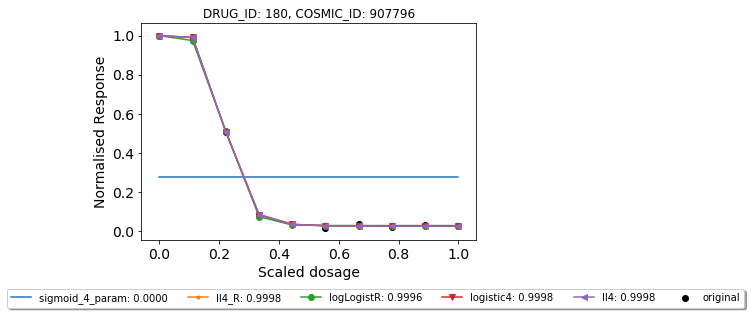

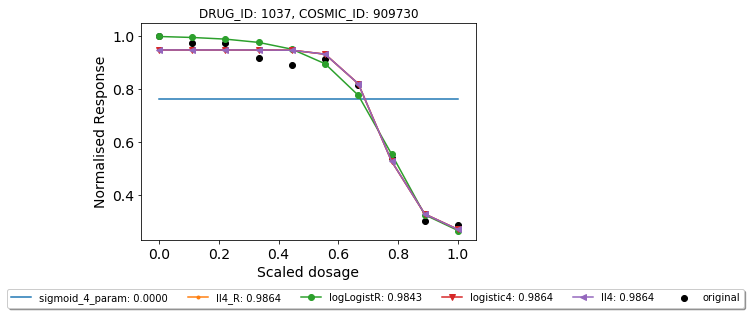

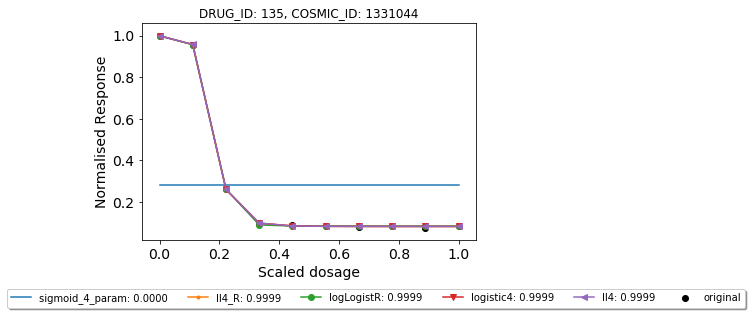

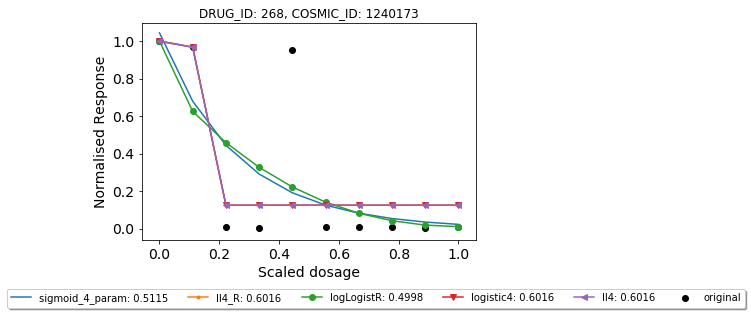

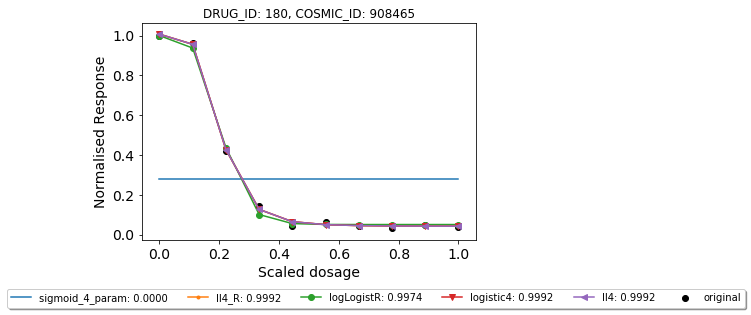

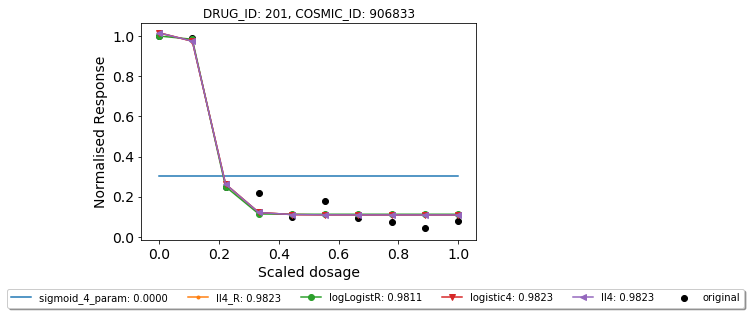

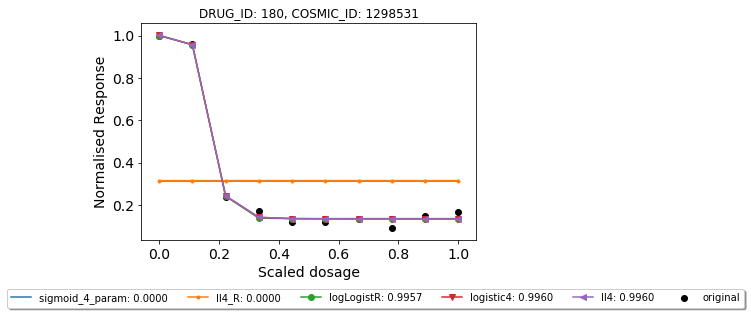

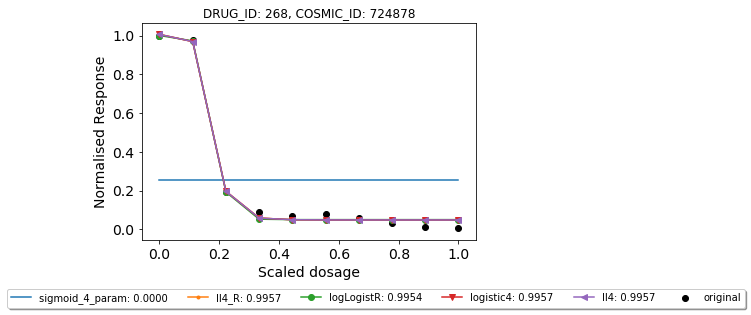

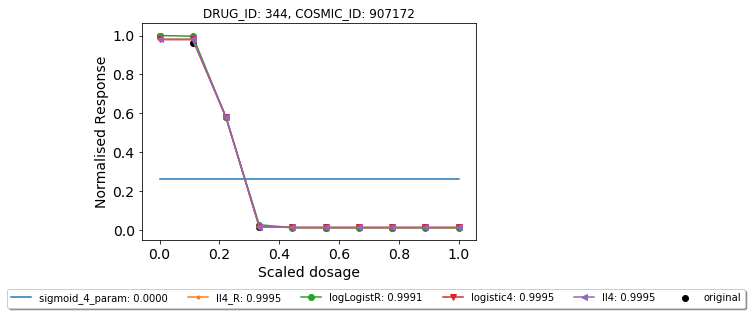

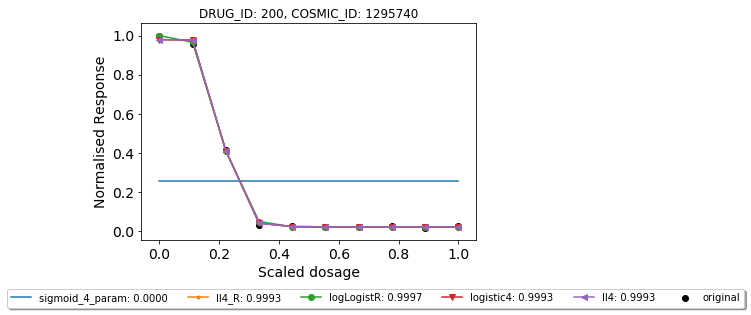

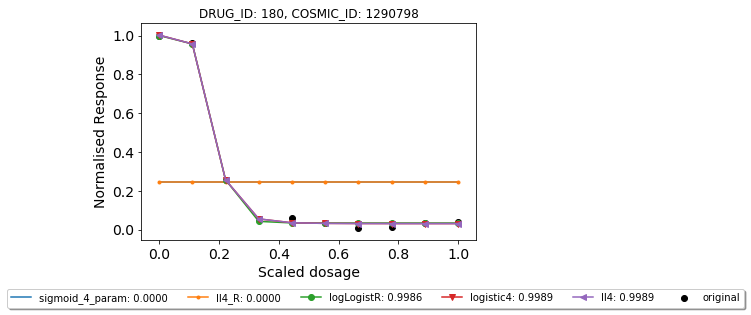

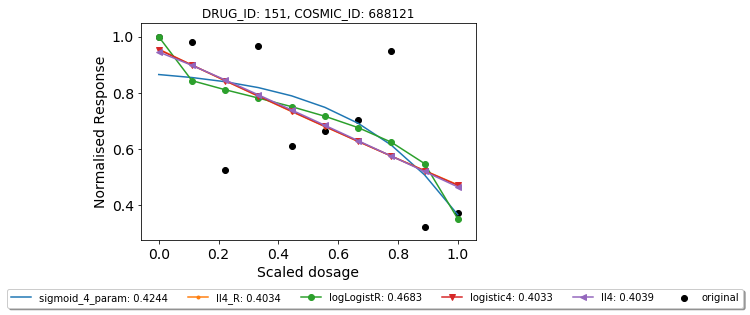

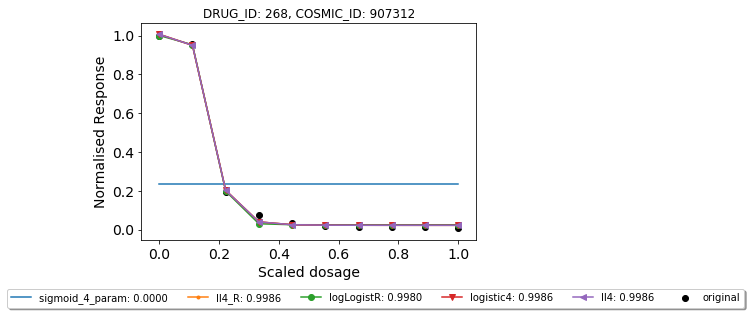

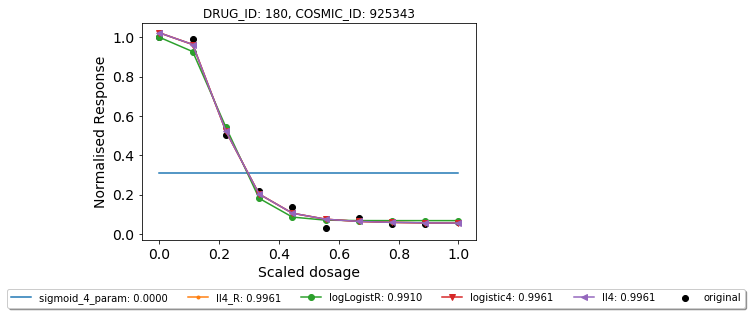

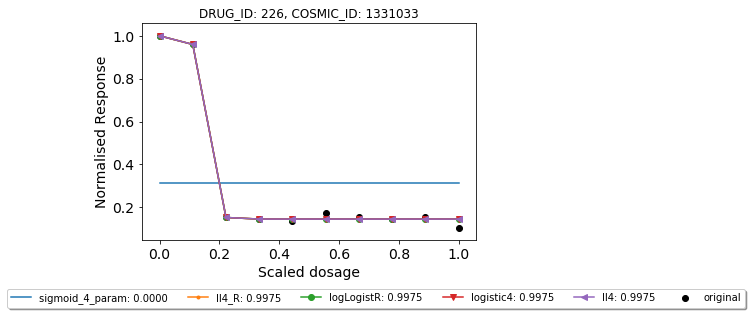

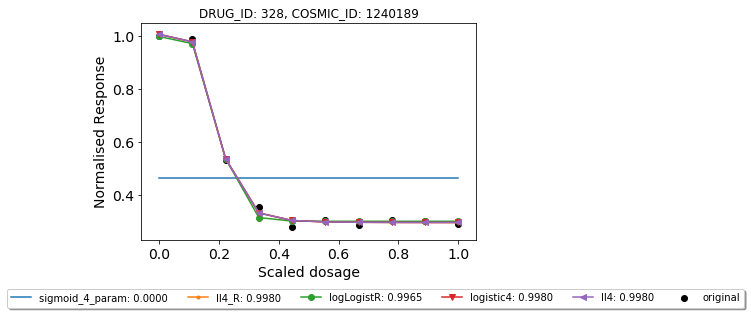

In [123]:
fitting_function = "sigmoid_4_param"
for i, ind in enumerate(df[df[fitting_function+"_r2"]<0.61].index):
    plt.figure(i)
    show_all_functions_on_one(drug_id =df.loc[ind, "DRUG_ID"], 
                                  cosmic_id= df.loc[ind, "COSMIC_ID"])
        

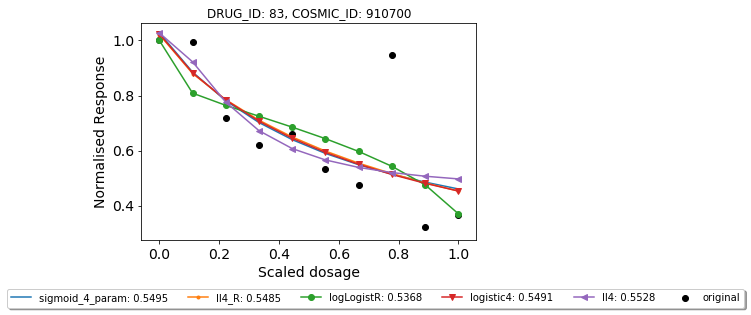

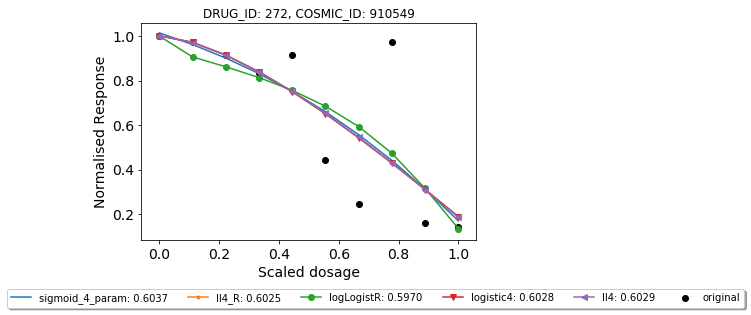

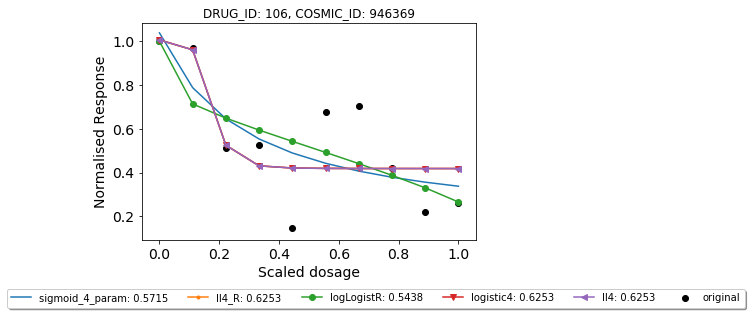

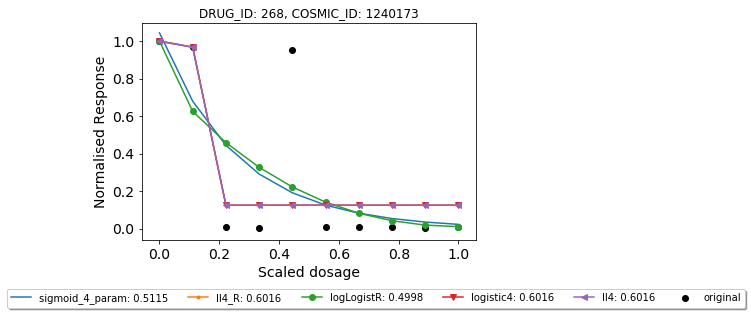

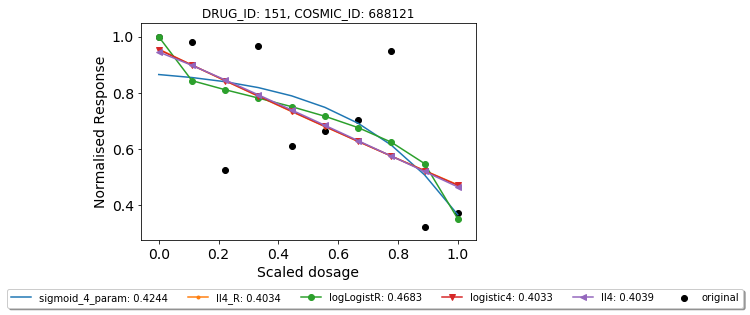

In [133]:
fitting_function = "logLogistR"
for i, ind in enumerate(df[df[fitting_function+"_r2"]<0.61].index):
    plt.figure(i)
    show_all_functions_on_one(drug_id =df.loc[ind, "DRUG_ID"], 
                                  cosmic_id= df.loc[ind, "COSMIC_ID"])

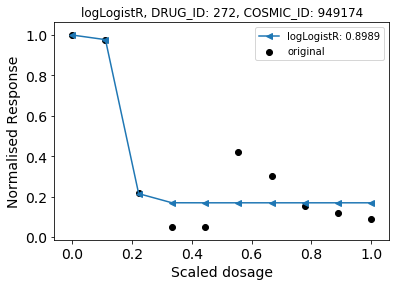

In [134]:
show_one(drug_id =272, cosmic_id= 949174, fitting_function = "logLogistR")

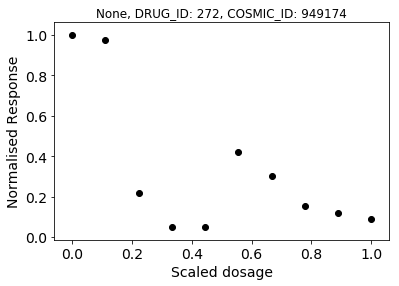

In [131]:
show_one(drug_id =272, cosmic_id= 949174, fitting_function = None)

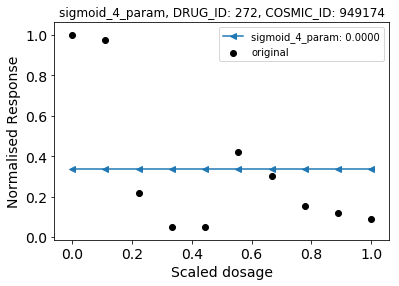

In [135]:
show_one(drug_id =272, cosmic_id= 949174, fitting_function = "sigmoid_4_param")

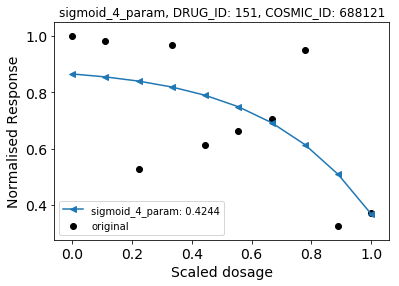

In [136]:
show_one(drug_id =151, cosmic_id= 688121, fitting_function = "sigmoid_4_param")

In [ ]:
df3 = pd.DataFrame(index= functions, columns = ["count", "min", "max"])
for fitting_function in functions:
    r2_fit = df[df["better_fitting"]==fitting_function][fitting_function+"_r2"].values 
#     print(fitting_function, len(r2_fit))
    df2.loc[fitting_function, "count"] = len(r2_fit)
    df2.loc[fitting_function, "min"] = min(r2_fit)
    df2.loc[fitting_function, "max"] = max(r2_fit)
df2

In [ ]:
df

In [ ]:
plt.figure(figsize=(4,3))
# ind = df.index[3]
ind =int(df[(df["DRUG_ID"]==135)& (df["COSMIC_ID"]==753610)].index[0])
fitting_parameters =fitting_function

x = df.loc[ind, conc_columns].astype("float32")
y = df.loc[ind, response_norm].astype("float32")
plt.scatter(x, y)
plt.tick_params(labelsize=14)
plt.xlabel("Scaled dosage", fontsize=14)
plt.ylabel("Normalised Response", fontsize=14)
# plt.savefig("filt_2.png", bbox_inches='tight');
fit_param = df.loc[ind, fitting_parameters]
y_fit = sigmoid_4_param(x, *fit_param)
r2 = r2_score(y, y_fit)
plt.plot(x, y_fit, label= "R^2 = %0.3f"% r2)
plt.legend()

In [32]:
r2_limit = 0.98
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

TypeError: '<' not supported between instances of 'dict_values' and 'dict_values'

In [ ]:
r2_limit = 0.95
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

In [ ]:
r2_limit = 0.9
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)